# Attenuation analysis for 15 rabbits on diet only

In [2]:
import h5py
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import matplotlib.patches as patches
sns.set_style('darkgrid')
import pickle
from matplotlib import gridspec
from matplotlib.lines import Line2D

from sklearn import svm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
os.chdir('/Users/trongnguyen/Dropbox/FattyLiver/src/hydrogen/')
from outlierDetection import getBSC_Att, envDetection, filter_BSC_based_on_depth, \
findOutliers, extract_segment_points

In [4]:
sns.set_context("poster", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}) 
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

In [5]:
%load_ext autoreload
%autoreload 2

### Load lipid labels and rabbit names

In [6]:
from helper_brl import fattyLiver

In [7]:
dataBase = fattyLiver.load_labels(threshold = 5)

In [8]:
#badRabbits = [729, 749, 750, 730, 751, 748, 753, 756]
badRabbits = [731, 740, 747, 739, 730, 741, 750, 749, 748, 751, 756]
for bad_rabbit in badRabbits:
    dataBase = dataBase[dataBase.Rabbit != bad_rabbit]
#badRabbits = [750, 752]

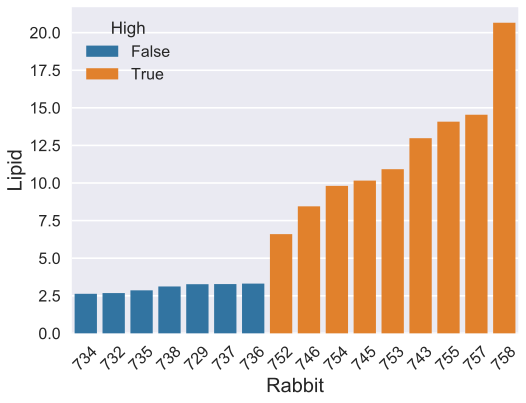

In [9]:
plt.figure(figsize = (8, 6))
g = sns.barplot(x = 'Rabbit', y = 'Lipid', hue = 'High' ,data = dataBase, dodge = False, order =dataBase['Rabbit'])
g1 = plt.xticks(rotation=45)

# Load data from hard drive

In [10]:
ATTs_dict, freq_att_dict, freq_bsc_dict, depth_dict, BSCs_dict = {}, {}, {}, {}, {} 
left_dict, right_dict, top_dict, bottom_dict = {}, {}, {}, {} # ROIs of each BSC
att_bottom, bad_BSC = {}, {}

In [11]:
name_tag = 'fix_bug_SonixOne_average_ref_phantom'
for index, row in dataBase.iterrows():
    number = row.Rabbit
    number = str(int(number))
    print(number, end = ', ')
    path = "/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L" + number + "/L94_left/BSC_ATT/"
    ATTs_dict[number], freq_att_dict[number], BSCs_dict[number], freq_bsc_dict[number], \
    depth_dict[number], left_dict[number], right_dict[number], \
    top_dict[number], bottom_dict[number], att_bottom[number], bad_BSC[number] = getBSC_Att(path,name_tag)

734, 732, 735, 738, 729, 737, 736, 752, 746, 754, 745, 753, 743, 755, 757, 758, 

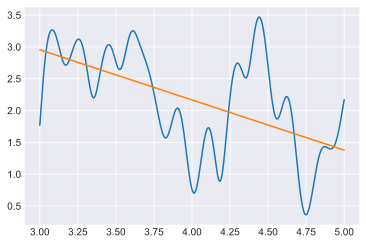

In [13]:
atts_one_rabbit = ATTs_dict['736']
atts_one_frame = atts_one_rabbit['23']
freq = freq_att_dict[number]['2'].flatten()

plt.plot(freq, atts_one_frame[:, 4])
slope, intercept = np.polyfit(freq, atts_one_frame[:,4], 1)
fitt_line = freq * slope + intercept
plt.plot(freq, fitt_line)

In [97]:
freq_4Mhz = (freq>= 4) 

In [98]:
freq_4Mhz

array([False, False, False, ...,  True,  True,  True], dtype=bool)

41
734,42
732,43
735,45
738,43
729,45
737,46
736,36
752,45
746,37
754,40
745,44
753,45
743,15
755,41
757,41
758,

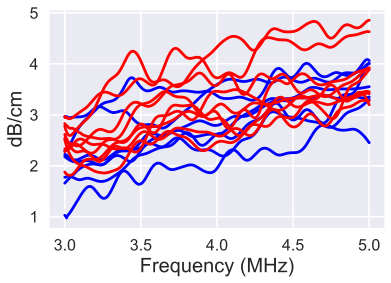

In [70]:
slope_att = {}
intercept_att = {}
slope_4MHZ = {}
rabbits_att_labels = {}
att_a = {}
att_b = {}
fig = plt.figure() #figsize = (10, 8)
ax = fig.add_subplot(1, 1, 1)
sns.set_style('darkgrid')
for index, row in dataBase.iterrows():
    number = str(int(row.Rabbit)) # for each rabbits
    lipid = row.Lipid #lipid
    atts = ATTs_dict[number] #all the frames
    first_key = next(iter(freq_att_dict[number]))
    print(first_key)
    freq = freq_att_dict[number][first_key].flatten()
    mean_att = np.zeros(1024)
    count1 = 0
    print(number, end = ',')
    
    for k, v in (atts.items()): # for all the frames in this rabbit
        mean_att_single_frame = np.zeros(1024)
        count = 0
        bottom_depth = att_bottom[number][k].flatten()
        for idx in range(bottom_depth.shape[0]): # goes through all the ROIs
            if ((bottom_depth[idx] < 53) and (bottom_depth[idx] >1)):
                slope, intercept = np.polyfit(freq, np.real(v[:, idx]), 1)
                #if (slope > 0): # if positive slope
                mean_att_single_frame = mean_att_single_frame + np.real(v[:, idx])
                count = count + 1
        if (count >0):
            
            mean_att_single_frame = mean_att_single_frame /count
            #ax.plot(freq, mean_att_single_frame, c = 'green')
            mean_att = mean_att + mean_att_single_frame
           
            count1 = count1 + 1
    if (count1 >0):
        #fig = plt.figure(figsize = (10, 8))
        #ax = fig.add_subplot(1, 1, 1)
        if (lipid > 5):
            ax.plot(freq, mean_att/count1, c = 'red')
        else:
            ax.plot(freq, mean_att/count1, c = 'blue')
        coeff = np.polyfit(np.ravel(freq), mean_att/count1, 1)
        if isinstance(coeff[0], complex):
            break
        freq1 = np.ravel(freq)
        att1 = mean_att/count1
  
        slope_att[lipid] = coeff[0]
        intercept_att[lipid] = coeff[1]
        #slope_4MHZ[lipid] = mean_att[freq_4mhz] /count1
        rabbits_att_labels[lipid] = number
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('dB/cm')
    #ax.set_title('Mean attenuation of L'+ number + ", Lipid: "+ str(lipid))
#print(len(slope_4MHZ))

In [66]:
def is_testing(k, rabbits_att_labels, testing_idx):
    if k in rabbits_att_labels:
        rabbit_no = (rabbits_att_labels[k])
        if (int(rabbit_no) in testing_idx):
            return True
        else:
            return False

In [67]:
no_testing = 2
count1 = 0
count2 = 0
total_rabbits = dataBase['Rabbit'].count()
testing_idx = []
while (count1 <no_testing):
    rand_idx = np.random.randint(1, total_rabbits)
    lipid = dataBase.iloc[rand_idx]['Lipid']
    Rabbit_number = int(dataBase.iloc[rand_idx]['Rabbit'])
    if ((Rabbit_number not in testing_idx) and (not dataBase.iloc[rand_idx]['High'])):
        testing_idx.append(Rabbit_number)
        count1 = count1 + 1
while (count2 <no_testing):
    rand_idx = np.random.randint(1, total_rabbits)
    lipid = dataBase.iloc[rand_idx]['Lipid']
    Rabbit_number = int(dataBase.iloc[rand_idx]['Rabbit'])
    if ((Rabbit_number not in testing_idx) and (dataBase.iloc[rand_idx]['High'])):
        testing_idx.append(Rabbit_number)
        count2 = count2 + 1

Text(0,0.5,'Attenuation intercept')

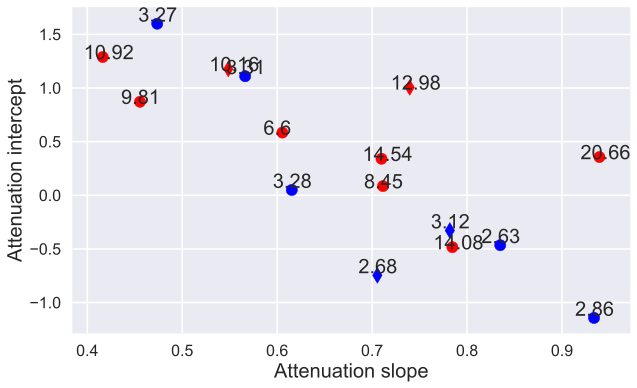

In [86]:
plt.figure(figsize = (10, 6))
sns.set_style('darkgrid')
x = np.zeros(len(slope_att))
y = np.zeros(len(slope_att))
X_1 = np.zeros((13, 2))
y_1 = np.zeros(13)
X_2 = np.zeros((4, 2))
y_2 = np.zeros(4)
count_train = 0
count = 0
count_test = 0
for k, v in slope_att.items():
    lipid = float(k)
  
    x[count] = slope_att[k]
    y[count] = intercept_att[k] ## slope_4MHZ[k] #
    if (not is_testing(k, rabbits_att_labels, testing_idx)):
        X_1[count_train,0] = intercept_att[k]
        X_1[count_train,1] = slope_att[k]
        y_1[count_train] = 1 if (float(k)>5) else 0
        count_train = count_train + 1
    else:
        X_2[count_test,0] = intercept_att[k]
        X_2[count_test,1] = slope_att[k]
        y_2[count_test] = 1 if (float(k)>5) else 0
        count_test = count_test + 1
    
    if (float(k)>5):
        
        if (not is_testing(k, rabbits_att_labels, testing_idx)):
            plt.scatter(x[count], y[count], c = 'r')
        else:
            plt.scatter(x[count], y[count], c = 'r', marker = 'd')
        plt.annotate(k, (x[count] - 0.02, y[count]-0.02))
    else:
        
        if (not is_testing(k, rabbits_att_labels, testing_idx)):
            plt.scatter(x[count], y[count], c = 'b')
        else:
            plt.scatter(x[count], y[count], c = 'b', marker = 'd')
        plt.annotate(k, (x[count] - 0.02, y[count] + 0.02))
    count = count + 1
plt.xlabel('Attenuation slope')
plt.ylabel('Attenuation intercept')

In [81]:
X = np.concatenate((X_1, X_2))
y = np.concatenate((y_1, y_2))

In [82]:
idx1 = np.where(y == 0)
print(np.mean(X[idx1, 1]), np.std(X[idx1, 1]))

0.613918209463 0.270774767638


In [83]:
idx2 = np.where(y == 1)
print(np.mean(X[idx2, 1]), np.std(X[idx2, 1]))

0.656727758744 0.156901840415


# Attenuation slope at 4 MHZ

0


Text(0,0.5,'Attenuation coefficient at 4MHz')

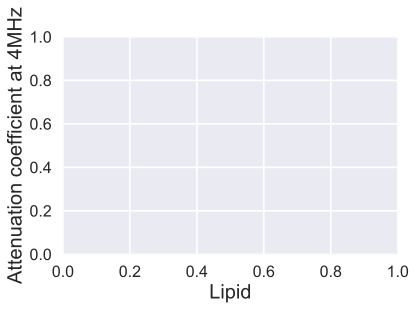

In [84]:
x1 = np.zeros(len(slope_4MHZ))
y1 = np.zeros(len(slope_4MHZ))

count = 0
for k, v in slope_4MHZ.items():
    lipid = float(k)
    x1[count] = lipid
    y1[count] = v
    #if ((lipid == 4.1) or (lipid == 13.76) or (lipid == 13.17)):
    #    print(lipid)
    #    continue
    if (lipid>10):
        plt.scatter(x1[count], y1[count], c = 'r')
        plt.annotate(k, (x1[count] -0.1, y1[count]-0.1))
    else:
        plt.scatter(x1[count], y1[count], c = 'b')
        plt.annotate(k, (x1[count] -0.1, y1[count]-0.1))
    count = count + 1
print(count)
plt.xlabel('Lipid')
plt.ylabel('Attenuation coefficient at 4MHz')

In [85]:
from scipy.stats import pearsonr
pearsonr(x1, y1)

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2998: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2999: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(nan, nan)

In [78]:
from mlxtend.plotting import plot_decision_regions

In [87]:
C = 1  # SVM regularizationaaparameter

svc = svm.SVC(kernel='rbf', C=100, gamma=0.1).fit(X, y)

plot_decision_regions(X_1, y_1.astype(np.integer), clf=svc, res=0.02, legend=1, colors = 'blue,red', markers ='oo')
plt.xlabel('Attenuation intercept')
plt.ylabel('Attenuation slope')

ValueError: Found input variables with inconsistent numbers of samples: [17, 16]

Text(0,0.5,'Attenuation slope')

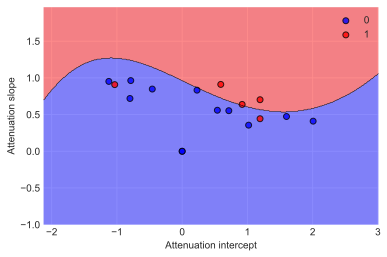

In [25]:
plot_decision_regions(X, y.astype(np.integer), clf=svc, res=0.02, legend=1, colors = 'blue,red', markers ='oo')
plt.xlabel('Attenuation intercept')
plt.ylabel('Attenuation slope')

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
print(classification_report(y_2, y_3))

             precision    recall  f1-score   support

        0.0       0.50      1.00      0.67         2
        1.0       0.00      0.00      0.00         2

avg / total       0.25      0.50      0.33         4



/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
cm = confusion_matrix(y_2, y_3)

In [30]:
cm

array([[2, 0],
       [2, 0]])

In [31]:
y_3 # predicted

array([ 0.,  0.,  0.,  0.])

In [32]:
y_2

array([ 0.,  0.,  1.,  1.])

In [33]:
n_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the accuracy
print(n_cm)

[[ 1.  0.]
 [ 1.  0.]]


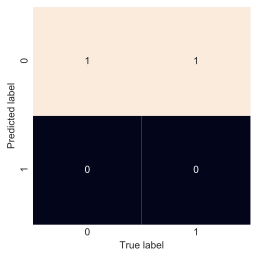

In [34]:
sns.heatmap(n_cm.T, square=True, annot=True, cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label');

734,2.63,732,2.68,735,2.86,738,3.12,729,3.27,737,3.28,736,3.31,752,6.6,746,8.45,754,9.81,745,10.16,753,10.92,743,12.98,755,14.08,757,14.54,758,20.66,

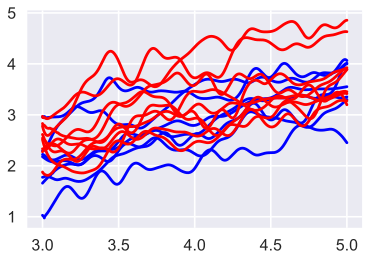

In [57]:
sns.set_style('darkgrid')
fig = plt.figure() #figsize = (10, 8)
ax = fig.add_subplot(1, 1, 1)

mean_att_low = np.zeros(1024)
mean_att_high = np.zeros(1024)
count_low = 0
count_high = 0
att_mean_dict = {}

att_curves_low = []
att_curves_high = []

for index, row in dataBase.iterrows():
    number = str(int(row.Rabbit)) # for each rabbits
    lipid = row.Lipid #lipid
    atts = ATTs_dict[number] #all the frames
    first_key = next(iter(freq_att_dict[number]))
    freq = freq_att_dict[number][first_key].flatten()
   

    print(number, end = ',')
    mean_att_single_frame = np.zeros(1024)
    count = 0
    for k, v in (atts.items()): # for all the frames in this rabbit        
        if (np.where(np.isnan(v) ==True)[0].size==0):
            mean_att_single_frame = mean_att_single_frame + np.mean(np.real(v), axis  = 1)
            count = count + 1
    print(lipid, end = ',')
    
    if (lipid <5):
        ax.plot(freq, mean_att_single_frame/count, c = 'b')
        mean_att_low = mean_att_low + mean_att_single_frame/count
        att_curves_low.append(mean_att_single_frame/count)
        
        count_low = count_low + 1
        att_mean_dict[number] = np.mean(mean_att_single_frame/count)
    else:
        ax.plot(freq, mean_att_single_frame/count, c = 'r')
        mean_att_high = mean_att_high + mean_att_single_frame/count
        att_curves_high.append(mean_att_single_frame/count)
        
        count_high = count_high + 1
        att_mean_dict[number] = np.mean(mean_att_single_frame/count)


/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'dB/cm')

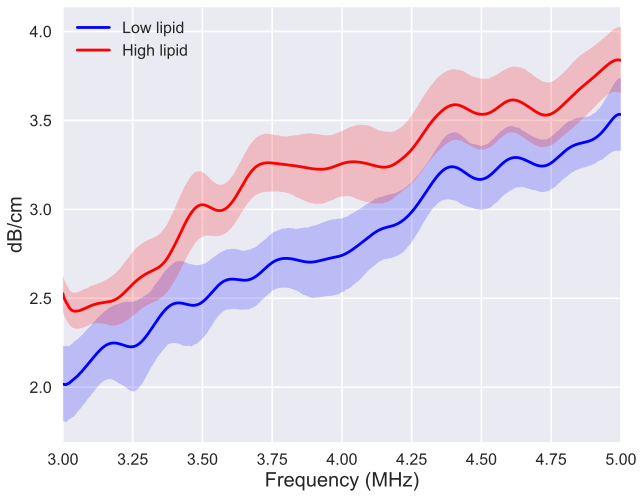

In [58]:
f, ax = plt.subplots(figsize=(10, 8))
#ax.set(yscale="log")
sns.tsplot(data = np.vstack(att_curves_low), time = freq,  color = 'b', condition = "Low lipid")
sns.tsplot(data =  np.vstack(att_curves_high),time = freq,  color = 'r', condition = 'High lipid')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('dB/cm')
#plt.xlabel('Frequency (MHz)')
#plt.ylabel('db/cm')
#ax.set_ylim([10**-4,10**-2])

In [1]:
att_mean_dict = {'729': 3.4936035961213925,
 '732': 2.0756001261422972,
 '734': 2.8743189312123372,
 '735': 2.5915748177984983,
 '736': 3.374863936594898,
 '737': 2.5109377185138397,
 '738': 2.7989711906499668,
 '743': 3.9634725554087225,
 '745': 3.3712449925688261,
 '746': 2.9311920288370152,
 '752': 3.0063926198588256,
 '753': 2.9538109578081935,
 '754': 2.6936006038110896,
 '755': 2.6541059453311742,
 '757': 3.179739288013324,
 '758': 4.1139757567414517}

Slope, intercept  0.701620810815 0.0106410877444
2.817124331
Slope, intercept 0.656727758744 0.580592825954
3.20750386093


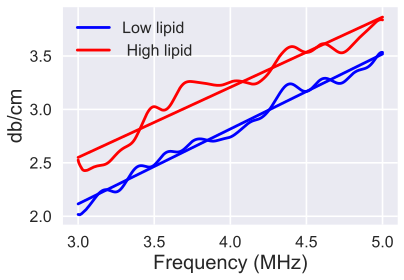

In [59]:
plt.plot(freq, mean_att_low/count_low, 'b')
slope1, intercept1 = np.polyfit(freq, mean_att_low/count_low, 1)
fitt_line1 = freq * slope1 + intercept1
plt.plot(freq, fitt_line1,'b', label = 'Low lipid')
print("Slope, intercept ", slope1, intercept1)
print(slope1 * 4 + intercept1)

plt.plot(freq, mean_att_high/count_high,'r')
slope2, intercept2 = np.polyfit(freq, mean_att_high/count_high, 1)
fitt_line2 = freq * slope2 + intercept2
plt.plot(freq, fitt_line2,'r', label = ' High lipid')
print("Slope, intercept", slope2, intercept2)
print(slope2 * 4 + intercept2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('db/cm')
plt.legend()

In [60]:
from scipy.stats import f_oneway

In [61]:
f_oneway(mean_att_low /count_low, mean_att_high/count_high)

F_onewayResult(statistic=480.33472366499598, pvalue=8.2089197197192889e-96)

In [18]:
testing_idx = [738, 737, 746, 745]

In [37]:
%qtconsole

In [19]:
att_train, att_y_train = fattyLiver.get_training_data(dataBase, testing_idx, ATTs_dict, freq_att_dict, False)
att_test, att_y_test = fattyLiver.get_testing_data(dataBase, testing_idx, ATTs_dict, freq_att_dict, False)

734,732,735,Skip,729,Skip,736,752,Skip,754,Skip,753,743,755,757,758,Skip, Skip, Skip, 738,Skip, 737,Skip, Skip, 746,Skip, 745,Skip, Skip, Skip, Skip, Skip, 

In [20]:
att_train.shape

(1024, 2164)

In [21]:
att_test.shape

(1024, 2015)

In [33]:
%qtconsole

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

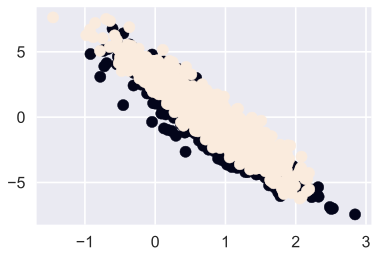

In [46]:
plt.scatter(ln_att_test[:,0], ln_att_test[:,1], c = att_y_test)

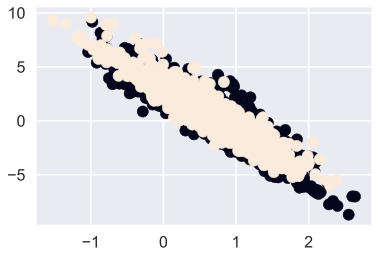

In [45]:
plt.scatter(ln_att_train[:,0], ln_att_train[:,1], c = att_y_train)

In [24]:
def linearFit(BSCs, f):
    lineFit = np.zeros((BSCs.shape[1], 2)) #allocate the matrix
    for i in range(0, BSCs.shape[1]):
        coeff = np.polyfit(np.ravel(f), BSCs[:, i], 1) # since BSCs is already in LOG form 
        lineFit[i,:] = coeff # fit a line into the BSCs
    return lineFit 

In [25]:
ln_att_train = linearFit(att_train, freq)

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [26]:
ln_att_test = linearFit(att_test, freq)

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [30]:
svc = svm.SVC(kernel='rbf', C=1, gamma=0.1).fit(ln_att_train, att_y_train)

In [31]:
att_y_predict = svc.predict(ln_att_test)

In [32]:
print(confusion_matrix(att_y_test, att_y_predict))

[[1098    8]
 [ 888   21]]


In [49]:
from mlxtend.plotting import plot_confusion_matrix

In [50]:
cm = confusion_matrix(att_y_test, att_y_predict)
n_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(n_cm)

[[ 1.  0.]
 [ 1.  0.]]


# plot ATT

734,

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


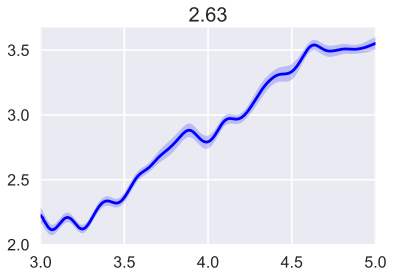

732,

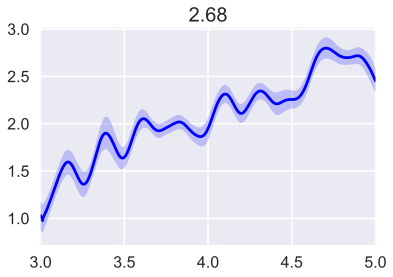

735,

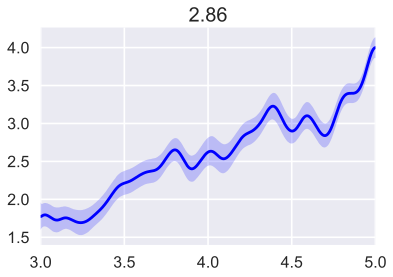

738,

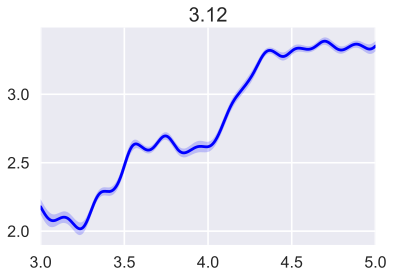

729,

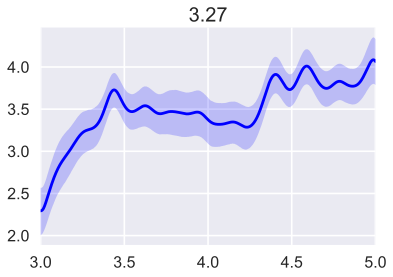

737,

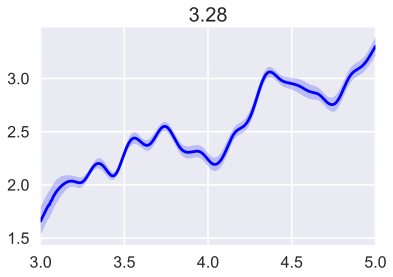

736,

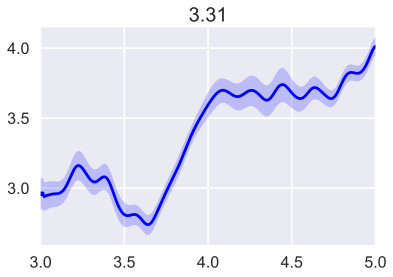

752,

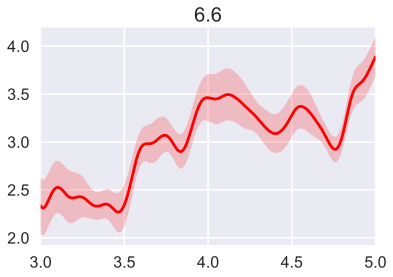

746,

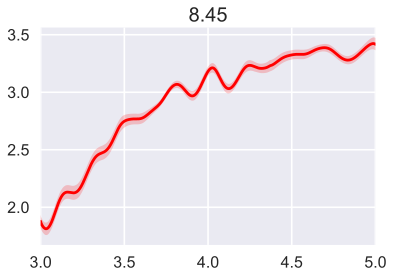

754,

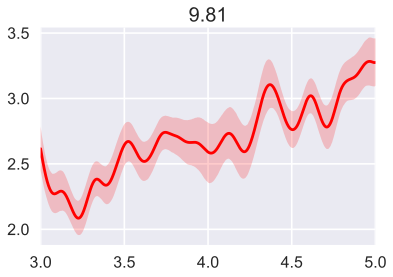

745,

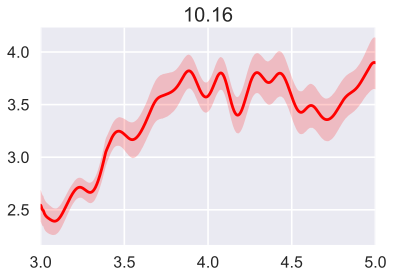

753,

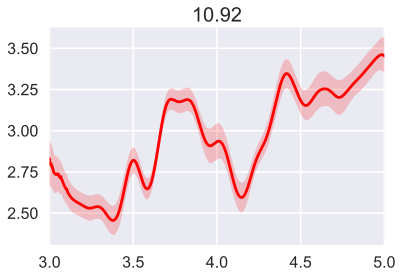

743,

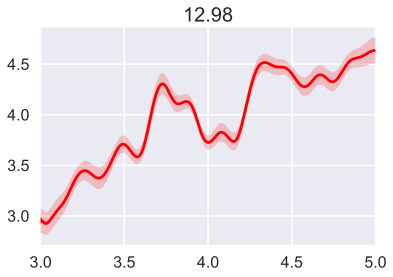

755,

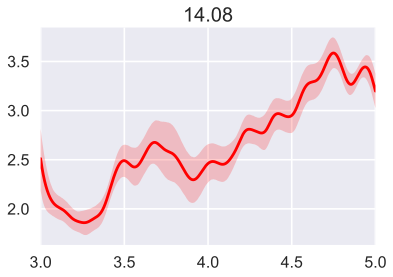

757,

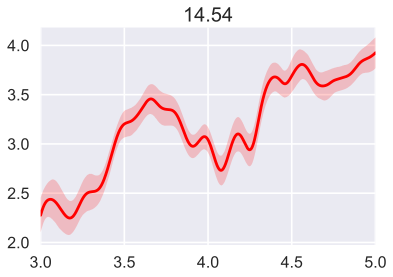

758,

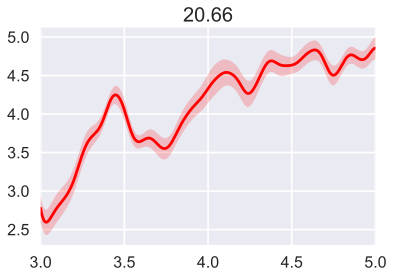

(0, 6)

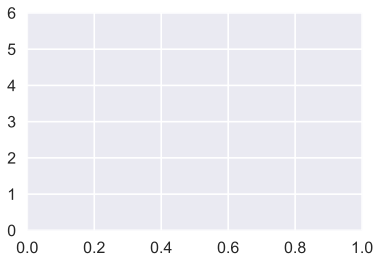

In [88]:
sns.set_style('darkgrid')

mean_att_low = np.zeros(1024)
mean_att_high = np.zeros(1024)
count_low = 0
count_high = 0

for index, row in dataBase.iterrows():
    number = str(int(row.Rabbit)) # for each rabbits
    lipid = row.Lipid #lipid
    atts = ATTs_dict[number] #all the frames
    first_key = next(iter(freq_att_dict[number]))
    
    freq = freq_att_dict[number][first_key].flatten()
  
    print(number, end = ',')
    mean_att_single_frame = np.zeros(1024)
    count = 0
    #fig = plt.figure() #figsize = (10, 8)
    #ax = fig.add_subplot(1, 1, 1)

    att_good = []
    for k, v in (atts.items()): # for all the frames in this rabbit    
        if (np.where(np.isnan(v) ==True)[0].size==0):
            att_good.append(np.mean(np.real(v), axis  = 1))
            #ax.plot(freq, np.mean(np.real(v), axis  = 1), c = 'r')
    if (lipid > 5):
        sns.tsplot(np.vstack(att_good), time = freq, color = 'r')       
    else:
        sns.tsplot(np.vstack(att_good), time = freq, color = 'b')       
    plt.title(str(lipid))
    plt.show()
plt.ylim([0,6])

In [60]:
dataBase

,Rabbit,Weeks on diet,Lipid,Injection level,High
0,734,1,2.63,2,False
1,732,1,2.68,1,False
2,735,3,2.86,2,False
3,738,6,3.12,3,False
4,729,0,3.27,0,False
5,737,3,3.28,3,False
7,736,0,3.31,3,False
10,752,1,6.60,0,False
13,751,1,8.20,0,True
14,746,6,8.45,2,True
